In [2]:
! pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 37.4 MB/s 
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 1.6 MB 59.2 MB/s 
     |████████████████████████████████| 5.8 MB 50.0 MB/s 
     |████████████████████████████████| 438 kB 27.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd 

In [3]:
spam_text = pd.read_csv('spam.csv',encoding='latin1')
spam_text.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
spam_text = spam_text[['v1','v2']]
spam_text.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
spam_text.groupby('v1').describe()

v2                                                               
     count unique                                                top freq
v1                                                                       
ham   4825   4516                             Sorry, I'll call later   30
spam   747    653  Please call our customer service representativ...    4

In [6]:
import numpy as np

In [7]:
ham = spam_text[spam_text['v1']=='ham'].sample(747)
ham

,v1,v2
5399,ham,And he's apparently bffs with carly quick now
2179,ham,And popping &lt;#&gt; ibuprofens was no help.
1753,ham,Jus came back fr lunch wif my sis only. U leh?
2150,ham,"The table's occupied, I'm waiting by the tree"
2042,ham,"Me not waking up until 4 in the afternoon, sup"
...,...,...
5494,ham,"Cool, we shall go and see, have to go to tip a..."
1699,ham,Ok...
1774,ham,"Its ok chikku, and its my 1 of favourite song...."
3962,ham,If you ask her or she say any please message.


In [8]:
spam = spam_text[spam_text['v1']=='spam']
spam

,v1,v2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [9]:
new_sampled_data = pd.concat([spam,ham])

In [10]:
new_sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494 entries, 2 to 1410
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      1494 non-null   object
 1   v2      1494 non-null   object
dtypes: object(2)
memory usage: 35.0+ KB


In [11]:
new_sampled_data['v1'] = new_sampled_data['v1'].apply(lambda x: 1 if x == 'spam' else 0)
new_sampled_data['v1'].value_counts()

1    747
0    747
Name: v1, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(new_sampled_data['v2'],new_sampled_data['v1'],stratify=new_sampled_data['v1'])

In [13]:
bert_preprocessor_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [14]:
encoder = hub.KerasLayer(bert_encoder_url)
preprocessor = hub.KerasLayer(bert_preprocessor_url)

In [15]:
def get_sentence_embeddings(sentence):
  preprocessed_sentence = preprocessor(sentence)
  encoded_sentence = encoder(preprocessed_sentence)
  return encoded_sentence['pooled_output']

Creating our Spam Classifier Using The Functional API in Tensorflow

In [19]:
# BERT Layers
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text = preprocessor(text_input)
output = encoder(preprocessed_text)
 # Neural Network Layers
layer1 = tf.keras.layers.Dropout(0.1,name='dropout_layer')(output['pooled_output'])
layer2 = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(layer1)

 # construct the final model
model = tf.keras.Model(inputs=[text_input],outputs=[layer2])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [21]:
from tensorflow import keras

In [22]:
from keras.utils import plot_model

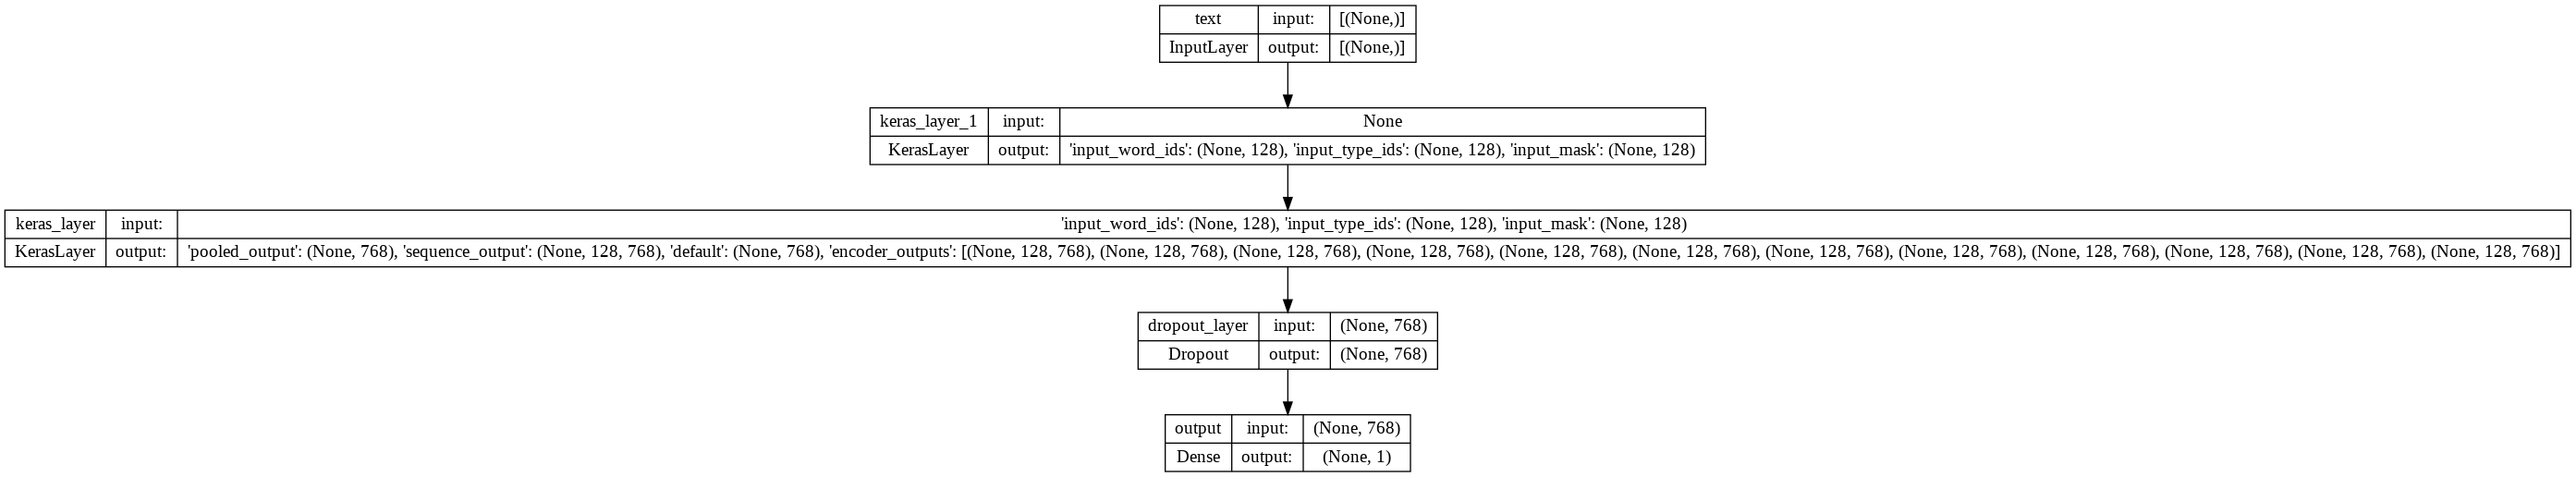

In [23]:
plot_model(model, to_file='model.png',show_shapes=True,show_layer_names=True)

In [25]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(
    metrics=METRICS,
    optimizer='adam',
    loss='binary_crossentropy'
)

In [26]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 22s 310ms/step - loss: 0.6371 - accuracy: 0.6348 - precision: 0.6355 - recall: 0.6321
Epoch 2/10
35/35 [==============================] - 11s 315ms/step - loss: 0.5173 - accuracy: 0.7875 - precision: 0.7885 - recall: 0.7857
Epoch 3/10
35/35 [==============================] - 11s 316ms/step - loss: 0.4413 - accuracy: 0.8455 - precision: 0.8330 - recall: 0.8643
Epoch 4/10
35/35 [==============================] - 11s 317ms/step - loss: 0.4021 - accuracy: 0.8598 - precision: 0.8541 - recall: 0.8679
Epoch 5/10
35/35 [==============================] - 11s 325ms/step - loss: 0.3708 - accuracy: 0.8687 - precision: 0.8518 - recall: 0.8929
Epoch 6/10
35/35 [==============================] - 12s 333ms/step - loss: 0.3458 - accuracy: 0.8830 - precision: 0.8757 - recall: 0.8929
Epoch 7/10
35/35 [==============================] - 11s 323ms/step - loss: 0.3166 - accuracy: 0.8973 - precision: 0.8995 - recall: 0.8946
Epoch 8/10
35/35 [================

In [27]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 5s 304ms/step - loss: 0.2609 - accuracy: 0.9332 - precision: 0.9133 - recall: 0.9572


[0.2609003186225891,
 0.9331550598144531,
 0.9132652878761292,
 0.9572192430496216]